# Security Investments (ROSI)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data preparation

In [2]:
# data source: https://surfdrive.surf.nl/files/index.php/s/CZWfWQp3VKGKa8m
df = pd.read_csv('../data_with_ports.csv.gz', sep='|', compression='gzip')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (15,17,19,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# parse string to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%dT%H:%M:%S+09:00')
df['stop_time'] = pd.to_datetime(df['stop_time'], format='%Y-%m-%dT%H:%M:%S+09:00')

In [4]:
# subset hosting providers only
dfASesHosting = df.loc[df["as_type"] == "hosting"]
#dfASesHosting.info() # premilary inspection

# drop columns with all null values
dfASesHosting.drop(columns=["tg_op", "subs"], inplace=True)

# fix null values in `region`
dfASesHosting[dfASesHosting.region.isna()][["cc", "region"]].drop_duplicates() # found US and CA have region = NaN
dfASesHosting.region.fillna("NA", inplace=True) # NA = North America

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [5]:
dfASesHosting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473792 entries, 2948 to 5697809
Data columns (total 33 columns):
target_ip                 473792 non-null object
date                      473792 non-null datetime64[ns]
sensor_id                 473792 non-null object
service                   473792 non-null object
start_time                473792 non-null datetime64[ns]
stop_time                 473792 non-null datetime64[ns]
duration                  473792 non-null float64
packets                   473792 non-null int64
raw_country               473792 non-null object
raw_as                    473792 non-null object
raw_hostname              473792 non-null object
udp_port_list             473792 non-null object
pyasn_as                  473792 non-null float64
pyasn_as_bgp_size         472991 non-null float64
cc                        473792 non-null object
region                    473792 non-null object
is_oecd                   473792 non-null float64
as_type                  

In [6]:
from random import randint

dfASesHosting.iloc[randint(0, len(dfASesHosting))]

target_ip                                                    193.138.77.158
date                                                    2014-12-08 00:00:00
sensor_id                                                         sensor001
service                                                                 dns
start_time                                              2014-12-08 04:03:20
stop_time                                               2014-12-08 04:13:15
duration                                                                595
packets                                                                1033
raw_country                                                          Latvia
raw_as                    AS12993 SIA Digitalas Ekonomikas Attistibas Ce...
raw_hostname                                    rev-193-138-77-158.deac.net
udp_port_list             [940, 2304, 2785, 4278, 4295, 7992, 7998, 8694...
pyasn_as                                                              12993
pyasn_as_bgp

## Metadata

Decsriptions of the metadata (Cheung, 2017):

| Column | Description |
| ------ | ----------- |
| `target_ip` | The IP address that has been targeted by a DDoS attackc |
| `date` | The date of attack |
| `sensor_id` | The name of the honeypot that monitored the attack traffic |
| `service` | The protocol that was used to execute the attack |
| `start_time` | The start time of the attack |
| `stop_time` | The stop time of the attack |
| `duration` | Attack duration |
| `pyasn_as` | The autonomous system number identifying which AS is routing traffic for the attacked IP |
| `pyasn_as_bpg_size` | The total number of IP addresses that the AS routes |
| `cc` | Short form of the country where the IP address seems to reside |
| `as_type` | The type of the Autonomous system (could be ISP, Hosting, EDU, etc.) |
| `tg_op` | A string identifier to ASes that are known to be Broadband ISPs |
| `caida_type` | A type identifier for ASes based on different source (CAIDA) |
| `dc` | The number of second level domains that have been observed to map to the attacked IP addresses in DNS traffic |
| `subs` | The number of subscribers for those ASes that are known to be Broadband ISPs |
| `as_ipsize_seen` | The total number of IP addresses of the AS that have been observed to be routed to IPs of the AS in DNS traffic |
| `as_domainsize_seen` | The total number of second level domains that have been observed to be routed to IPs of the AS in DNS traffic |
| `year` | The year of the attack |
| `udp_port_list` | The ports that attack packets have been sent to |


## Hosting providers

In [7]:
def secondLevelDomainName(raw_hostname):
    '''get second-level domain name'''
    if raw_hostname.count(".") >= 2:
        d3, d2, d1 = raw_hostname.rsplit(".", 2)
        if (d2 == "com") | (d2 == "co"): # e.g. "co.uk" or "com.br" 
            return raw_hostname
        else:
            return d2 + "." + d1
    else:
        return raw_hostname

In [8]:
hostingDomains = dfASesHosting[~dfASesHosting.raw_hostname.isna()]
hostingDomains = hostingDomains[hostingDomains.raw_hostname != "None"]
hostingDomains['hostname'] = hostingDomains.raw_hostname.apply(secondLevelDomainName)
hostingDomains.head()

,target_ip,date,sensor_id,service,start_time,stop_time,duration,packets,raw_country,raw_as,...,org_ipsize_seen_shared,org_is_hosting,org_tag,caida_type,dc,as_ipsize_seen,as_domainsize_seen,pps,year,hostname
2948,100.42.49.140,2014-12-25,sensor003,ssdp,2014-12-25 13:47:59,2014-12-25 14:07:44,1185.0,441,United States,AS36351 SoftLayer Technologies Inc.,...,4944.0,1.0,hosting,Content,1982,542087.0,3384037.0,0.372152,2014,arvixe.com
2949,100.42.49.140,2014-12-25,sensor005,ssdp,2014-12-25 13:47:51,2014-12-25 14:07:49,1198.0,433,United States,AS36351 SoftLayer Technologies Inc.,...,4944.0,1.0,hosting,Content,1982,542087.0,3384037.0,0.361436,2014,arvixe.com
2950,100.42.49.140,2014-12-25,sensor007,ssdp,2014-12-25 13:47:50,2014-12-25 14:07:46,1196.0,440,United States,AS36351 SoftLayer Technologies Inc.,...,4944.0,1.0,hosting,Content,1982,542087.0,3384037.0,0.367893,2014,arvixe.com
2951,100.42.52.96,2014-12-23,sensor001,dns,2014-12-23 17:33:13,2014-12-23 17:48:00,887.0,491,United States,AS36351 SoftLayer Technologies Inc.,...,4944.0,1.0,hosting,Content,628,542087.0,3384037.0,0.553551,2014,mysitehosted.com
2952,100.42.57.238,2014-12-20,sensor001,ntp,2014-12-20 13:48:46,2014-12-20 13:50:47,121.0,2927,United States,AS21788 Network Operations Center Inc.,...,4944.0,1.0,hosting,Content,2,542087.0,3384037.0,24.190083,2014,mysitehosted.com


In [9]:
# top ten hosting providers under most attacks
mostAttackedHostingProviders = hostingDomains.hostname.value_counts()[:10]
mostAttackedHostingProviders

amazonaws.com            16469
your-server.de           15856
poneytelecom.eu          13582
lstn.net                  7391
softlayer.com             6454
alojandoargentina.net     5366
ovh.net                   4535
kimsufi.com               3416
as15003.net               2070
beastnode.com             2016
Name: hostname, dtype: int64

In [11]:
# as_ipsize_seen

hostingDomains_IpSizeSeen = {
    host : hostingDomains.loc[hostingDomains.hostname == host]
                         .as_ipsize_seen
                         .value_counts()
                         .reset_index()
    for host in mostAttackedHostingProviders.index
}

# weighted domain size

hostingDomains_IpSizeSeenWeighted = {
    host: (d["index"] * d["as_ipsize_seen"]).sum() / d["as_ipsize_seen"].sum()
    for (host, d) in hostingDomains_IpSizeSeen.items()
}

hostingDomains_IpSizeSeenWeighted = pd.DataFrame.from_dict(hostingDomains_IpSizeSeenWeighted, 
                                                           orient="index", columns=["ipsize_seen_weighted"])
hostingDomains_IpSizeSeenWeighted

,ipsize_seen_weighted
amazonaws.com,781597.918574
your-server.de,391410.000000
poneytelecom.eu,84462.000000
lstn.net,26579.000000
softlayer.com,542016.094360
alojandoargentina.net,12935.060380
ovh.net,599916.000000
kimsufi.com,599916.000000
as15003.net,506145.000000
beastnode.com,88208.625000


In [12]:
# as_domainsize_seen

hostingDomains_DomainSizeSeen = {
    host : hostingDomains.loc[hostingDomains.hostname == host]
                         .as_domainsize_seen
                         .value_counts()
                         .reset_index()
    for host in mostAttackedHostingProviders.index
}

# weighted domain size

hostingDomains_DomainSizeSeenWeighted = {
    host: (d["index"] * d["as_domainsize_seen"]).sum() / d["as_domainsize_seen"].sum()
    for (host, d) in hostingDomains_DomainSizeSeen.items()
}

hostingDomains_DomainSizeSeenWeighted = pd.DataFrame.from_dict(hostingDomains_DomainSizeSeenWeighted, 
                                                               orient="index", columns=["domainsize_seen_weighted"])
hostingDomains_DomainSizeSeenWeighted

,domainsize_seen_weighted
amazonaws.com,4.080514e+06
your-server.de,4.552561e+06
poneytelecom.eu,5.121730e+05
lstn.net,4.238320e+05
softlayer.com,3.383592e+06
alojandoargentina.net,1.092719e+05
ovh.net,5.984318e+06
kimsufi.com,5.984318e+06
as15003.net,1.170958e+06
beastnode.com,1.057769e+06


In [13]:
hostingDomainsMostAttacked = hostingDomains[hostingDomains.hostname.isin(mostAttackedHostingProviders.index.tolist())]
hostingDomainsMostAttacked.sort_values(by="hostname")
hostingDomainsMostAttacked[["hostname", "pps"]].sample(5)

,hostname,pps
375805,poneytelecom.eu,23.862069
573427,ovh.net,0.896552
4833458,softlayer.com,13.451084
383573,beastnode.com,2.000000
2522002,your-server.de,30.314286


In [14]:
idSortByMostAttacks = pd.DataFrame(mostAttackedHostingProviders.index, 
                                   columns=["hostname"]).reset_index()
hostingDomainsMostAttacked = (hostingDomainsMostAttacked.merge(idSortByMostAttacks, how="left", 
                                                               left_on="hostname", right_on="hostname")
                                                        .sort_values(by="index", ascending=False))
hostingDomainsMostAttacked[["hostname", "pps"]].head()

,hostname,pps
77154,beastnode.com,5.176471
42993,beastnode.com,5.972650
42999,beastnode.com,3.501967
42998,beastnode.com,3.444444
42997,beastnode.com,0.768537


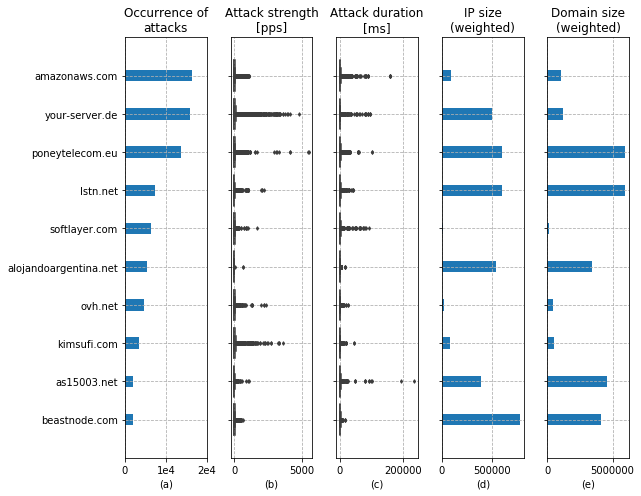

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(9, 7), sharey=True)

sns.boxplot(data=hostingDomainsMostAttacked, x="pps", y="hostname", orient="h", 
            fliersize=2.5, ax=ax[1])
ax[1].set_ylabel("")
ax[1].set_xlabel("(b)")
ax[1].set_title("Attack strength\n[pps]")

sns.boxplot(data=hostingDomainsMostAttacked, x="duration", y="hostname", orient="h", 
            fliersize=2.5, ax=ax[2])
ax[2].set_ylabel("")
ax[2].set_xlabel("(c)")
ax[2].set_title("Attack duration\n[ms]")

ax[0].barh(mostAttackedHostingProviders.index, mostAttackedHostingProviders.values, height=0.3)
ax[0].set_title("Occurrence of\nattacks")
ax[0].set_xlabel("(a)")
ax[0].set_xlim([0, 20000])
ax[0].set_xticklabels(["0", "1e4", "2e4"])

ax[3].barh(hostingDomains_IpSizeSeenWeighted.index,
           hostingDomains_IpSizeSeenWeighted.ipsize_seen_weighted, height=0.3)
ax[3].set_title("IP size\n(weighted)")
ax[3].set_xlabel("(d)")

ax[4].barh(hostingDomains_DomainSizeSeenWeighted.index,
           hostingDomains_DomainSizeSeenWeighted.domainsize_seen_weighted, height=0.3)
ax[4].set_title("Domain size\n(weighted)")
ax[4].set_xlabel("(e)")

ax[0].invert_yaxis()
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')
ax[2].grid(linestyle='--')
ax[3].grid(linestyle='--')
ax[4].grid(linestyle='--')

plt.tight_layout()
fig.savefig("images/top-ten-host-providers.png")

## Performance among hosting providers

In [18]:
hostingDomains.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317792 entries, 2948 to 5697809
Data columns (total 34 columns):
target_ip                 317792 non-null object
date                      317792 non-null datetime64[ns]
sensor_id                 317792 non-null object
service                   317792 non-null object
start_time                317792 non-null datetime64[ns]
stop_time                 317792 non-null datetime64[ns]
duration                  317792 non-null float64
packets                   317792 non-null int64
raw_country               317792 non-null object
raw_as                    317792 non-null object
raw_hostname              317792 non-null object
udp_port_list             317792 non-null object
pyasn_as                  317792 non-null float64
pyasn_as_bgp_size         317522 non-null float64
cc                        317792 non-null object
region                    317792 non-null object
is_oecd                   317792 non-null float64
as_type                  

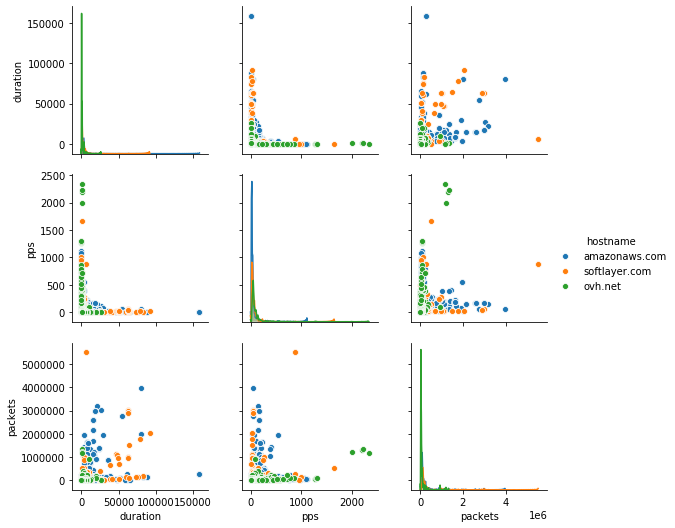

In [53]:
hosting = ["amazonaws.com", "ovh.net", "softlayer.com"]

sns.pairplot(hostingDomains[hostingDomains.hostname.isin(hosting)][["duration", "pps", "packets", "hostname"]], 
             hue="hostname", diag_kind="kde")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

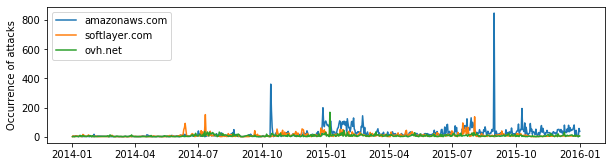

In [59]:
fig, ax = plt.subplots(figsize=(10, 2.5))

ax.plot(hostingDomains[hostingDomains.hostname == "amazonaws.com"].groupby("date").hostname.value_counts().unstack())
ax.plot(hostingDomains[hostingDomains.hostname == "softlayer.com"].groupby("date").hostname.value_counts().unstack())
ax.plot(hostingDomains[hostingDomains.hostname == "ovh.net"].groupby("date").hostname.value_counts().unstack())
ax.legend(["amazonaws.com", "softlayer.com", "ovh.net"])
ax.set_ylabel("Occurrence of attacks")

fig.savefig("images/attacks-per-day-three-hosting")

In [58]:
hostingDomains[hostingDomains.hostname == "amazonaws.com"] # "2015-08-30"

hostname,amazonaws.com
date,
2015-08-30,848
2014-10-13,361
2014-12-27,199
2015-10-09,194
2014-10-14,178
2015-02-22,144
2015-07-28,130
2015-02-09,129
2015-01-31,124


## Misc

In [ ]:
# fix null values in `org`

dfASesHosting[dfASesHosting.org.isna()][["raw_hostname", "raw_as", "org"]].drop_duplicates()

In [ ]:
dfASesHosting[dfASesHosting.raw_as.str.contains("SoftLayer")].raw_as.unique()


In [ ]:
dfASesHosting[dfASesHosting.raw_as.str.contains("Amazon")][["raw_as", "org", "caida_type"]].drop_duplicates()

In [ ]:
dfASesHosting.loc[dfASesHosting.raw_as == "AS21844 SoftLayer Technologies Inc."][["target_ip", "raw_hostname", "raw_as", "org", "caida_type"]].drop_duplicates()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.date.value_counts().sort_index())
ax.set_title("Number of observed DDoS attacks per day")

In [ ]:
# number of attacks per day, per AS type

nrAttacksPerASType = (df[["as_type", "date"]].groupby("date")
                                             .as_type.value_counts()
                                             .unstack().fillna(0))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(nrAttacksPerASType)
ax.set_title("Number of observed DDoS attacks per day, per AS type")
ax.legend(nrAttacksPerASType.columns.tolist(), title="AS type")

In [ ]:
# AS victims, ISP broadband & hosting

asesHosting = df.loc[df["as_type"] == "hosting"]
asesIspBroadband = df.loc[df["as_type"] == "isp-broadband"]

In [ ]:
asesHostingNrAttacks = asesHosting.org.value_counts()

In [ ]:
# top ten hosting providers under most attacks 
asesHostingNrAttacks[:10]

In [ ]:
(asesHosting.loc[asesHosting.org == "Amazon.com"]
            .loc[asesHosting.as_ipsize_seen == 748413.0]
            [["org", "as_ipsize_seen", "raw_as"]]
            .drop_duplicates())


In [ ]:
(asesHosting.loc[asesHosting.org.isin(asesHostingNrAttacks.index.tolist()[:10])]
                [["org", "as_ipsize_seen", "as_domainsize_seen", "org_tag"]].drop_duplicates())

In [ ]:
(asesHosting.loc[asesHosting.org == "Amazon.com"]
                [["org", "as_ipsize_seen", "as_domainsize_seen", "org_tag", "raw_as", "raw_hostname"]].drop_duplicates())

In [ ]:
# number of attacks against hosting providers per day, per org

nrAttacksHostingPerOrg = (asesHosting.loc[asesHosting.org.isin(asesHostingNrAttacks.index.tolist()[:5])]
                                         [["org", "date"]]
                                     .groupby("date")
                                     .org.value_counts()
                                     .unstack()
                                     .fillna(0))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(nrAttacksHostingPerOrg)
ax.set_title("Occurence of DDoS attacks against hosting providers per day, \ntop five companies under most attacks")
# ax.set_yscale('log')
ax.legend(nrAttacksHostingPerOrg.columns.tolist(), title="Company")
ax.figure.savefig("images/nrAttacksHostingTopFiveOrgs.png")

In [ ]:
asesRawAsAmazon = asesHosting.loc[asesHosting.raw_as.str.contains("Amazon")]

asesRawAsAmazon.loc[asesRawAsAmazon.org == "Facebook"].iloc[0]